选择合适的两个资产构建配对交易策略，其中两个资产对数价格间的协整关系采用kalman滤波进行估计

数据使用期货焦炭和焦煤。

Trddt [交易日期] - 以yyyy-mm-dd表示  
Agmtcd [合约代码] -   
Trdvar [交易品种] -   
Fdt001 [交易所代码] - 指期货交易所简写代码DCE=大连交易所、SHFE=上海交易所、CZCE=郑州交易所  
Fdt002 [交割期] - 以交易所公布为准  
Fdt003 [日开盘价] -   
Fdt004 [日最高价] -   
Fdt005 [日最低价] -   
Fdt006 [日收盘价] -   
Fdt007 [日结算价] - 为期货合约成交价格按成交量的加权平均价格，是用以确定保证金帐户每天盈亏的价格。  
Fdt010 [成交量] - 指某个期货合约在特定时间内的买卖数量。  
Fdt011 [持仓量] - 又称未平仓量，是某种商品期货合约尚未以相反期货交易或实物交割冲销的数量。  
Fdt012 [持仓量变化] -   
Fdt013 [成交金额] -   

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch.unitroot import ADF
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

#### 1 获得焦煤和焦炭数据

In [2]:
j_path = '国内期货日交易数据113426157/FUT_Fdt.csv'
jm_path = '国内期货日交易数据113254269/FUT_Fdt.csv'

jdata = pd.read_csv(j_path)
jmdata = pd.read_csv(jm_path)
#只考虑主力合约
jdata = jdata.sort_values(by=['Trddt','Fdt010'],ascending=[1,0]).groupby('Trddt').head(1)
jmdata = jmdata.sort_values(by=['Trddt','Fdt010'],ascending=[1,0]).groupby('Trddt').head(1)
#收盘价不能交易，使用开盘价
factor = ['Trddt','Agmtcd','Fdt003','Fdt006']
newfactor = ['Trddt','Agmtcd','Opnprc','Clsprc']

jdata = jdata[factor].reset_index(drop=True)
jdata.columns = newfactor
jmdata = jmdata[factor].reset_index(drop=True)
jmdata.columns = newfactor

#### 1.1 价格取对数 

In [3]:
jdata['lnprc'] = np.log(jdata['Opnprc'])
jmdata['lnprc'] = np.log(jmdata['Opnprc'])

#### 1.2 数据整理

In [4]:
df = jdata.merge(jmdata,on='Trddt')
prcdf = df[['Trddt','lnprc_x','lnprc_y']]
prcdf.columns = ['Trddt','Fdt_J','Fdt_JM']
prcdf = prcdf.set_index('Trddt')
prcdf

,Fdt_J,Fdt_JM
Trddt,,
2013-03-22,7.431892,7.154615
2013-03-25,7.430707,7.151485
2013-03-26,7.425358,7.134891
2013-03-27,7.419381,7.153834
2013-03-28,7.413367,7.142037
...,...,...
2022-11-15,7.903042,7.660585
2022-11-16,7.915713,7.677864
2022-11-17,7.935408,7.680176


In [5]:
prcdf.loc['2018-12-28']

Fdt_J     7.543803
Fdt_JM    7.066467
Name: 2018-12-28, dtype: float64

#### 2 固定beta测试

In [6]:
#区分训练数据和测试数据取固定beta
prcdf_train = prcdf.loc[:'2018-12-28']

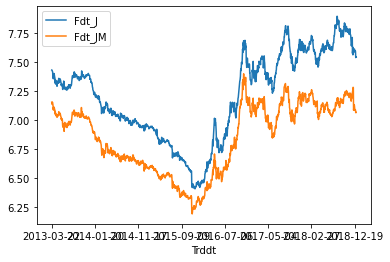

In [7]:
prcdf_train.plot()
plt.show()

In [8]:
#序列平稳性检验
print(ADF(prcdf_train['Fdt_J']))
print(ADF(prcdf_train['Fdt_JM']))

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.404
P-value                         0.581
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.352
P-value                         0.605
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


均不拒绝零假设，不平稳

#### 2.1 协整检验

In [9]:
#使用coint函数
result = coint(prcdf_train['Fdt_J'],prcdf_train['Fdt_JM'],trend='c',method='aeg')
print('coint_t:',result[0])
print('pvalue:',result[1])
print('crit_value:\n',\
      '[1%]',result[2][0],'\n',\
      '[5%]',result[2][1],'\n',\
     '[10%]',result[2][2])

coint_t: -3.129544420938852
pvalue: 0.08252161740908637
crit_value:
 [1%] -3.9042408022129176 
 [5%] -3.3404760904938198 
 [10%] -3.047465730768434


In [10]:
#一元线性回归
reg = sm.OLS(prcdf_train['Fdt_J'], sm.add_constant(prcdf_train['Fdt_JM'])).fit()
print(reg.summary())

alpha = reg.params[0]
beta = reg.params[1]
residual = prcdf_train['Fdt_J'] - beta * prcdf_train['Fdt_JM'] - alpha
#检验平稳性
print(ADF(residual))

                            OLS Regression Results                            
Dep. Variable:                  Fdt_J   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 2.927e+04
Date:                Thu, 24 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:44:42   Log-Likelihood:                 1552.8
No. Observations:                1408   AIC:                            -3102.
Df Residuals:                    1406   BIC:                            -3091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2644      0.050    -25.517      0.0

在训练数据上协整，尝试包含测试数据效果。

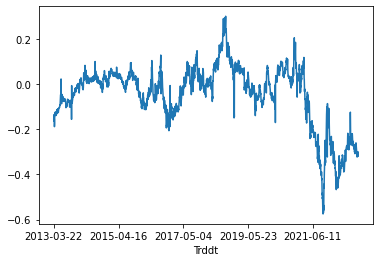

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.546
P-value                         0.105
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.557
P-value                         0.505
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [11]:
#固定beta
residual_all=prcdf['Fdt_J'] - beta * prcdf['Fdt_JM'] - alpha
residual_all.plot()
plt.show()
print(ADF(residual_all))
print(ADF(residual_all.loc['2018-12-28':]))

在训练数据上表现良好，在测试数据上固定beta表现一般。需要动态调整beta！

ARIMA模型预测的基本思想：  
（一）根据时间序列的散点图、自相关函数和偏自相关函数图以ADF单位根检验其方差、趋势及其季节性变化规律，对序列的平稳性进行识别。一般来讲，经济运行的时间序列都不是平稳序列。  
（二）对非平稳序列进行平稳化处理。如果数据序列是非平稳的，并存在一定的增长或下降趋势，则需要对数据进行差分处理，如果数据存在异方差，则需对数据进行技术处理，直到处理后的数据的自相关函数值和偏相关函数值无显著地异于零。  
（三）根据时间序列模型的识别规则，建立相应的模型。若平稳序列的偏相关函数是截尾的，而自相关函数是拖尾的，可断定序列适合AR模型；若平稳序列的偏相关函数是拖尾的，而自相关函数是截尾的，则可断定序列适合MA模型；若平稳序列的偏相关函数和自相关函数均是拖尾的，则序列适合ARMA模型。  
（四）进行参数估计，检验是否具有统计意义。  
（五）进行假设检验，诊断残差序列是否为白噪声。  
（六）利用已通过检验的模型进行预测分析。

In [12]:
#ARIMA模型，可以结合Kalman滤波进行跨品种期货套利
from statsmodels.tsa.arima.model import ARIMA
armodel = ARIMA(residual.values, order=(1,0,0)).fit()
print(armodel.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1408
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3664.222
Date:                Thu, 24 Nov 2022   AIC                          -7322.444
Time:                        20:44:51   BIC                          -7306.694
Sample:                             0   HQIC                         -7316.558
                               - 1408                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.416e-07      0.017  -4.85e-05      1.000      -0.034       0.034
ar.L1          0.9738      0.005    184.475      0.000       0.963       0.984
sigma2         0.0003   3.65e-06     87.942      0.0

### 3 Kalman滤波
https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/

In [13]:
#import pandas_datareader.data as web
from pykalman import KalmanFilter
#计算J对JM的价格回归的斜率和回归的截距
def calc_slope_intercept_kalman(prcdf):       
    delta = 1e-5 # 控制过渡协方差矩阵的噪音
    trans_cov = delta / (1 - delta) * np.eye(2) # 过渡协方差矩阵
    # 创建观测矩阵：一个一维矩阵存储JM的值
    obs_mat = np.vstack([prcdf['Fdt_JM'],np.ones(prcdf['Fdt_JM'].shape)]).T[:,np.newaxis]

    # 创建卡尔曼滤波器实例
    kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,#状态，这里是2，要求的是线性回归的斜率和截距
    initial_state_mean=np.zeros(2),#斜率和截距的状态均值初始化为0
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,#观测矩阵
    observation_covariance=1.0,
    transition_covariance=trans_cov
    )

    # 调用过滤器。计算截距和斜率的状态。
    state_means, state_covs = kf.filter(prcdf['Fdt_J'].values)
    return state_means, state_covs

def draw_slope_intercept_changes(prcdf, state_means):
    #从卡尔曼滤波器计算结果，绘制斜率和截距的变化
    #slope斜率beta，intercept截距alpha
    pd.DataFrame(\
        dict(slope=state_means[:,0],intercept=state_means[:,1]),\
        index=prcdf.index)\
    .plot(subplots=True)
    plt.show()


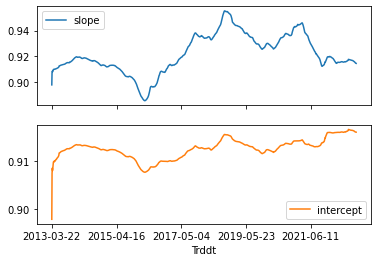

In [14]:
state_means, state_covs = calc_slope_intercept_kalman(prcdf)
draw_slope_intercept_changes(prcdf,state_means)

In [15]:
prcdf['beta'] = state_means[:,0]
prcdf['alpha'] = state_means[:,1]
#std
#prcdf['std'] = 
prcdf['spread'] = prcdf['Fdt_J'] - prcdf['beta']*prcdf['Fdt_JM'] - prcdf['alpha']

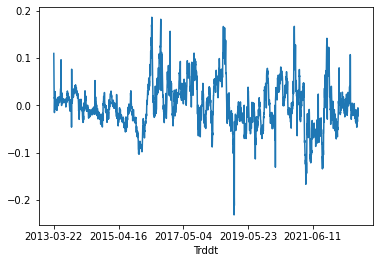

In [16]:
prcdf['spread'].plot()
plt.show()

直观可见spread为平稳的均值回复过程。

In [17]:
print(ADF(prcdf['spread']).pvalue)
print(ADF(prcdf['spread'].loc['2018-12-28':]).pvalue)

2.6847801235174388e-09
9.153075489963251e-05


动态估计的beta，平稳性检验其实没有意义。

#### 4 交易过程

In [18]:
#生成仓位状态position，其中data需包括spread

def tradetest(df1,multiplier,std):
    df2 = df1.copy()
    start_date = '2013-03-22'
    #生成指标，简单处理，使用固定区间
    df2['r_mean'] = 0
    df2['r_std'] = std
    #生成多空信号
    df2['low_band'] = df2['r_mean']-multiplier*df2['r_std']
    df2['high_band'] = df2['r_mean']+multiplier*df2['r_std']
          
    '''plt.rcParams['figure.figsize'] = (12, 6)
    plt.plot(df2.index,df2['spread'])
    plt.plot(df2.index,df2['low_band'])
    plt.plot(df2.index,df2['high_band'])
    plt.show()'''
       
    #生成仓位信号
    df2['longs_Entry'] = df2['spread']<df2['low_band']
    df2['longs_Exit'] = df2['spread']>df2['r_mean']  #0

    df2['shorts_Entry'] = df2['spread']>df2['high_band']
    df2['shorts_Exit'] = df2['spread']<df2['r_mean']  #0
    #生成仓位
    df2.loc[start_date,'Long'] = 0
    df2.loc[df2['longs_Entry'],'Long'] = 1
    df2.loc[df2['longs_Exit'],'Long'] = 0
    
    df2.loc[start_date,'Short'] = 0
    df2.loc[df2['shorts_Entry'],'Short'] = -1
    df2.loc[df2['shorts_Exit'],'Short'] = 0
    #补全仓位状态
    df2['newLong'] = df2['Long'].fillna(method='ffill')
    df2['newShort'] = df2['Short'].fillna(method='ffill')
    #持仓
    df2['position'] = df2['newLong'] + df2['newShort']
    #输出
    df3 = df1.copy()
    df3['position'] = df2['position']
    return df3

In [19]:
multiplier=1
std = 0.05
tradingdf = tradetest(prcdf,multiplier,std)
#tradingdf[tradingdf['position']==1]
tradingdf

,Fdt_J,Fdt_JM,beta,alpha,spread,position
Trddt,,,,,,
2013-03-22,7.431892,7.154615,0.897870,0.897870,0.110106,-1.0
2013-03-25,7.430707,7.151485,0.904672,0.904669,0.056289,-1.0
2013-03-26,7.425358,7.134891,0.907356,0.907348,0.044124,-1.0
2013-03-27,7.419381,7.153834,0.907998,0.907989,0.015723,-1.0
2013-03-28,7.413367,7.142037,0.908500,0.908488,0.016342,-1.0
...,...,...,...,...,...,...
2022-11-15,7.903042,7.660585,0.914707,0.915949,-0.020097,0.0
2022-11-16,7.915713,7.677864,0.914634,0.915942,-0.022665,0.0
2022-11-17,7.935408,7.680176,0.914618,0.915940,-0.004960,0.0


In [20]:
tradingdf['spread_diff'] = tradingdf['spread'] - tradingdf['spread'].shift(1)

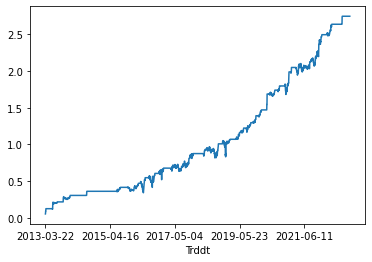

In [21]:
#当期收益由上一期position決定
#不会算return，直接用对数价差了
ret = tradingdf['position'].shift(1)*(tradingdf['spread'] - tradingdf['spread'].shift(1))
ret.cumsum().plot()
plt.show()

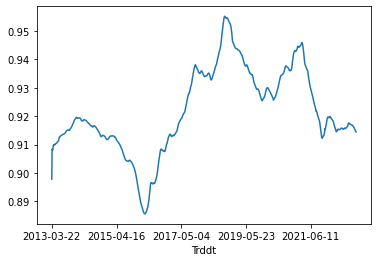

In [22]:
tradingdf['beta'].plot()
plt.show()

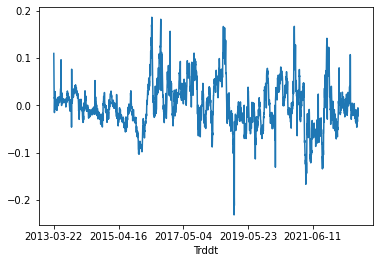

In [24]:
tradingdf['spread'].plot()
plt.show()